In [2]:
import sys, os
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from scipy.integrate import quad, nquad
from sklearn.preprocessing import normalize
from sktree.tree import DecisionTreeClassifier
from sktree.ensemble import HonestForestClassifier
from sktree.stats import FeatureImportanceForestClassifier
from sklearn.metrics import roc_auc_score
from scipy.stats import entropy

import numpy as np
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.integrate import simps
from scipy.stats import entropy
from scipy.stats import gamma
from sklearn import metrics
from sktree.datasets import make_trunk_classification, make_trunk_mixture_classification

## Multi-Modal

In [101]:
def true_mi_multi_modal(mu0,mu1,sig0,sig1,p0= [0.5,0.5],p1=[0.5,0.5]):
    n = 10000
    p = sig0[0].shape[0]
    p_class0 = p_class1 = 0.5
    # print(mu0,mu1)
    pdf_class0_1 = multivariate_normal(mean = mu0[0], cov = sig0[0],allow_singular=True)
    pdf_class0_2 = multivariate_normal(mean = mu0[1], cov = sig0[1],allow_singular=True)
    pdf_class1_1 = multivariate_normal(mean = mu1[0], cov = sig1[0],allow_singular=True)
    pdf_class1_2 = multivariate_normal(mean = mu1[1], cov = sig1[1],allow_singular=True)

    # print(pdf_class0_1.rvs(size = int(n*p0[0])).shape)
    x_0_1 = pdf_class0_1.rvs(size = int(n*p0[0])).reshape((int(n*p0[0]),p))
    x_0_2 = pdf_class0_2.rvs(size = int(n*p0[1])).reshape((int(n*p0[1]),p))
    x_1_1 = pdf_class1_1.rvs(size = int(n*p1[0])).reshape((int(n*p1[0]),p))
    x_1_2 = pdf_class1_2.rvs(size = int(n*p1[1])).reshape((int(n*p1[1]),p))

    # print(x_1_1)
    x_0 = np.vstack([x_0_1,x_0_2])
    x_1 = np.vstack([x_1_1,x_1_2])
    x = np.vstack((x_0_1,x_0_2,x_1_1,x_1_2))
    # if p ==2:
    #     plt.scatter(x_0[:,0], x_0[:,1], color = 'red',cmap='viridis',s = 5,alpha = 0.2)
    #     plt.scatter(x_1[:,0], x_1[:,1], cmap='viridis',s = 5,alpha = 0.5)
    # # print(x.shape)
    y = [0]*n+[1]*n

    p_x_given_class0_1 = np.nan_to_num(pdf_class0_1.pdf(x))
    p_x_given_class0_2 = np.nan_to_num(pdf_class0_2.pdf(x))
    p_x_given_class1_1 = np.nan_to_num(pdf_class1_1.pdf(x))
    p_x_given_class1_2 = np.nan_to_num(pdf_class1_2.pdf(x))

    p_x_given_class0 = p0[0]*p_x_given_class0_1+p0[1]*p_x_given_class0_2
    p_x_given_class1 = p1[0]*p_x_given_class1_1+p1[1]*p_x_given_class1_2


    p_x = p_x_given_class0*p_class0 + p_x_given_class1*p_class1
    # pos_class0 = p_x_given_class0*p_class0/p_x

    pos_class0 = (np.array([p_x_given_class0[i]*p_class0/p_x[i] if p_x[i] != 0 else 0 for i in range(p_x.shape[0])]).reshape(-1,1))
    pos_class1 = np.ones(pos_class0.shape) - pos_class0
    posterior = np.hstack((pos_class0.reshape(-1,1),pos_class1.reshape(-1,1)))

    stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))
    prior_y = np.array([p_class0,p_class1])
    entropy_y = entropy(prior_y, base=np.exp(1))
    # print('entropy'+str(stats_conen))
    MI = entropy_y - stats_conen

    fpr, tpr, thresholds = metrics.roc_curve(y, posterior[:,1], pos_label=1,drop_intermediate = False)
    plt.plot(fpr, tpr,label = 'dimension' + str(p))
    plt.legend()
    s98 = np.max(tpr[fpr<=0.02])

    auc = roc_auc_score(y, posterior[:,1])

    return x,y,MI,s98,auc



In [102]:
def _moving_avg_cov(n_dim, rho):
    # Create a meshgrid of indices
    i, j = np.meshgrid(np.arange(1, n_dim + 1), np.arange(1, n_dim + 1), indexing="ij")

    # Calculate the covariance matrix using the corrected formula
    cov_matrix = rho ** np.abs(i - j)

    # Apply the banding condition
    cov_matrix[abs(i - j) > 1] = 0
    return cov_matrix

[array([[1, 0],
       [0, 1]]), array([[1, 0],
       [0, 1]])]
0.2239


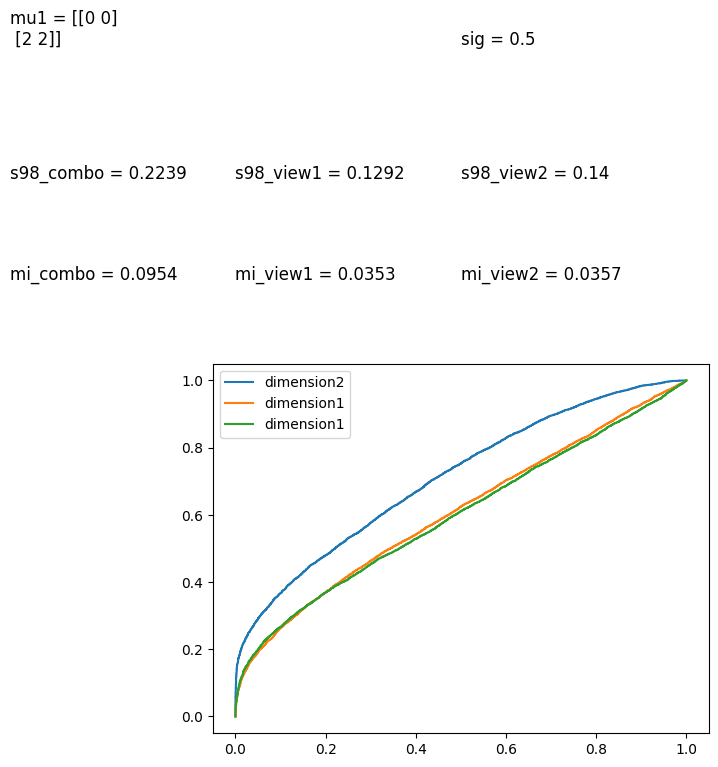

In [115]:
n = 10000
rho = 0.5
mu_0 = np.array([[0,0],[0,0]])
mu_1 = np.array([[0,0],[2,2]])
sig0 = _moving_avg_cov(2, 0)
sig1 = _moving_avg_cov(2, rho)
sig_0 = [sig0 ,sig0]
print(sig_0)
sig_1 = [sig1 ,sig1]

x,y,mi_combo,s98_combo,auc_combo = true_mi_multi_modal(mu_0,mu_1,sig_0,sig_1,p0= [0.75,0.25],p1=[0.75,0.25])
_,_,mi_view1,s98_view1,auc_view1 =  true_mi_multi_modal(mu_0[:,0],mu_1[:,0],[np.identity(1),np.identity(1) ],[np.identity(1),np.identity(1) ],p0= [0.75,0.25],p1=[0.75,0.25])
_,_,mi_view2,s98_view2,auc_view2 = true_mi_multi_modal(mu_0[:,1],mu_1[:,1],[np.identity(1),np.identity(1) ],[np.identity(1),np.identity(1) ],p0= [0.75,0.25],p1=[0.75,0.25])


y = [0]*n+[1]*n
# scatter plot, dots colored by class value
print(s98_combo)
# plt.scatter(x[:,0], x[:,1], c=y, cmap='viridis',s = 5,alpha = 0.5)
# # print the s98 in the plot
# plt.text(-4, 10.0, 'mu1 = '+str(mu_1), fontsize=12)
# plt.text(1,10.0, 'sig = '+str(rho), fontsize=12)
# plt.text(-4, 8, 's98_combo = '+str(s98_combo), fontsize=12)
# plt.text(1, 8, 's98_view1 = '+str(s98_view1), fontsize=12)
# plt.text(6, 8, 's98_view2 = '+str(s98_view2), fontsize=12)
# plt.text(-4, 7, 'mi_combo = '+str(np.round(mi_combo,4)), fontsize=12)
# plt.text(1, 7, 'mi_view1 = '+str(np.round(mi_view1,4)), fontsize=12)
# plt.text(6, 7, 'mi_view2 = '+str(np.round(mi_view2,4)), fontsize=12)
# plt.show()

plt.text(-0.5, 2, 'mu1 = '+str(mu_1), fontsize=12)
plt.text(0.5,2, 'sig = '+str(rho), fontsize=12)
plt.text(-0.5, 1.6, 's98_combo = '+str(s98_combo), fontsize=12)
plt.text(0, 1.6, 's98_view1 = '+str(s98_view1), fontsize=12)
plt.text(0.5, 1.6, 's98_view2 = '+str(s98_view2), fontsize=12)
plt.text(-0.5, 1.3, 'mi_combo = '+str(np.round(mi_combo,4)), fontsize=12)
plt.text(0, 1.3, 'mi_view1 = '+str(np.round(mi_view1,4)), fontsize=12)
plt.text(0.5, 1.3, 'mi_view2 = '+str(np.round(mi_view2,4)), fontsize=12)
plt.show()

In [113]:
mu_1[1,:]

array([0, 2])

In [22]:
sig_0[0]

array([[1. , 0.5],
       [0.5, 1. ]])

In [90]:
p = 2
n_mu = len(np.arange(-5, 5))
n_sig = len(np.arange(-0.8,1,0.2))
MI = np.zeros((n_mu,n_sig))
s98_comb = np.zeros((n_mu,n_sig))
s98_v1 = np.zeros((n_mu,n_sig))
s98_v2 = np.zeros((n_mu,n_sig))
mi_comb = np.zeros((n_mu,n_sig))
mi_v1 = np.zeros((n_mu,n_sig))
mi_v2 = np.zeros((n_mu,n_sig))
s98 = np.zeros((n_mu,n_sig))

for i, mu in enumerate(np.arange(-5, 5)):
    for j, rho in enumerate(np.arange(-0.8,1,0.2)):
        mu_0 = np.zeros((2,2))
        mu_1 = np.array([[0,0],[-mu,mu]])     
        # print(mu_1)
        # print(j,rho)
        sig0 = _moving_avg_cov(2, 0)
        sig1 = _moving_avg_cov(2, rho)
        sig_0 = [sig0 ,sig0]
        sig_1 = [sig1 ,sig1]
        # print(sig_0,sig_1)
        _,_,mi_combo,s98_combo,auc_combo = true_mi_multi_modal(mu_0,mu_1,sig_0,sig_1,p0= [0.75,0.25],p1=[0.75,0.25])
        _,_,mi_view1,s98_view1,auc_view1 =  true_mi_multi_modal(mu_0[:,0],mu_1[:,0],[np.identity(1),np.identity(1) ],[np.identity(1),np.identity(1) ],p0= [0.75,0.25],p1=[0.75,0.25])
        _,_,mi_view2,s98_view2,auc_view2 = true_mi_multi_modal(mu_0[:,1],mu_1[:,1],[np.identity(1),np.identity(1) ],[np.identity(1),np.identity(1) ],p0= [0.75,0.25],p1=[0.75,0.25])

        MI[i,j] = mi_combo - (mi_view1+mi_view2)
        s98_comb[i,j] = s98_combo
        s98_v1[i,j] = s98_view1
        s98_v2[i,j] = s98_view2
        mi_comb[i,j] = mi_combo
        mi_v1[i,j] = mi_view1
        mi_v2[i,j] = mi_view2
        s98[i,j] = s98_combo - (s98_view1+s98_view2)



Text(0.5, 1.0, 'S98_Combo')

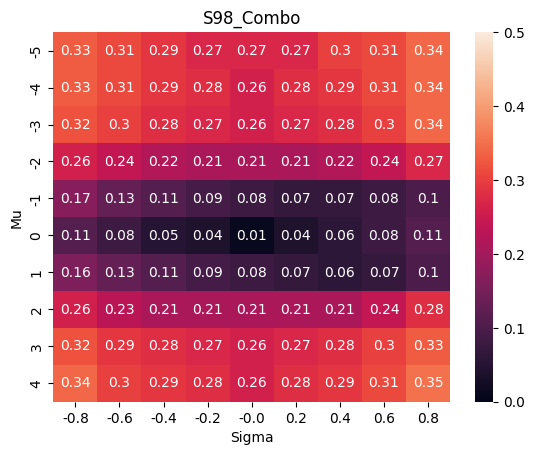

In [91]:
import pandas as pd
import seaborn as sns
s98_comb_df = pd.DataFrame(np.round(s98_comb,2),index = np.arange(-5, 5) ,columns = np.round(np.arange(-0.8,1,0.2),2))
sns.heatmap(s98_comb_df,annot = True,vmin = 0,vmax = 0.5)
plt.xlabel('Sigma')
plt.ylabel('Mu')
plt.title("S98_Combo")



Text(0.5, 1.0, 'S98_View1')

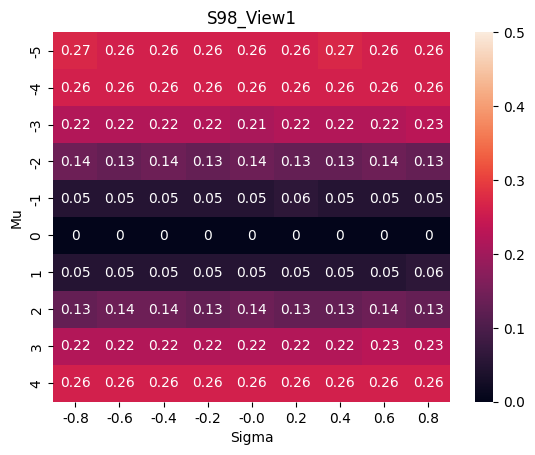

In [92]:
s98_view1_df = pd.DataFrame(np.round(s98_v1,2),index = np.arange(-5, 5) ,columns = np.round(np.arange(-0.8,1,0.2),2))
sns.heatmap(s98_view1_df,annot = True,vmin = 0,vmax = 0.5)
plt.xlabel('Sigma')
plt.ylabel('Mu')
plt.title("S98_View1")



Text(0.5, 1.0, 'S98_View2')

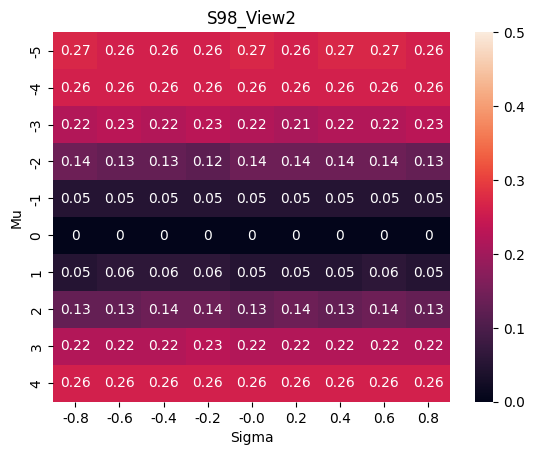

In [93]:
s98_view2_df = pd.DataFrame(np.round(s98_v2,2),index = np.arange(-5, 5) ,columns = np.round(np.arange(-0.8,1,0.2),2))
sns.heatmap(s98_view2_df,annot = True,vmin = 0,vmax = 0.5)
plt.xlabel('Sigma')
plt.ylabel('Mu')
plt.title("S98_View2")

Text(0.5, 1.0, 'MI_Combo')

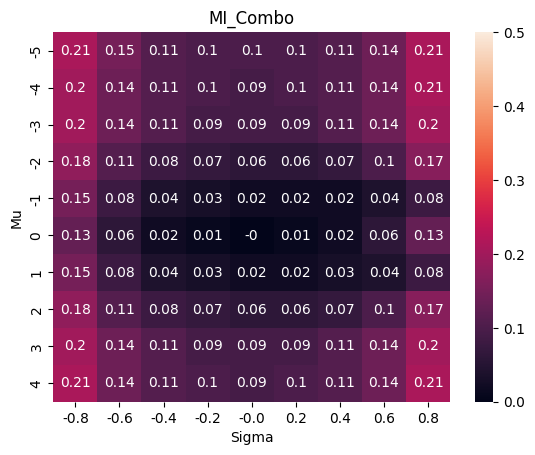

In [94]:
mi_comb_df = pd.DataFrame(np.round(mi_comb,2),index = np.arange(-5, 5) ,columns = np.round(np.arange(-0.8,1,0.2),2))
sns.heatmap(mi_comb_df,annot = True,vmin = 0,vmax = 0.5)
plt.xlabel('Sigma')
plt.ylabel('Mu')
plt.title("MI_Combo")

Text(0.5, 1.0, 'MI_View1')

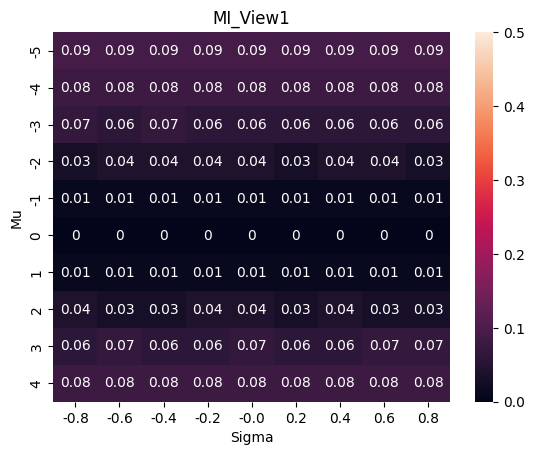

In [95]:
mi_view1_df = pd.DataFrame(np.round(mi_v1,2),index = np.arange(-5, 5) ,columns = np.round(np.arange(-0.8,1,0.2),2))
sns.heatmap(mi_view1_df,annot = True,vmin = 0,vmax = 0.5)
plt.xlabel('Sigma')
plt.ylabel('Mu')
plt.title("MI_View1")

Text(0.5, 1.0, 'MI_View2')

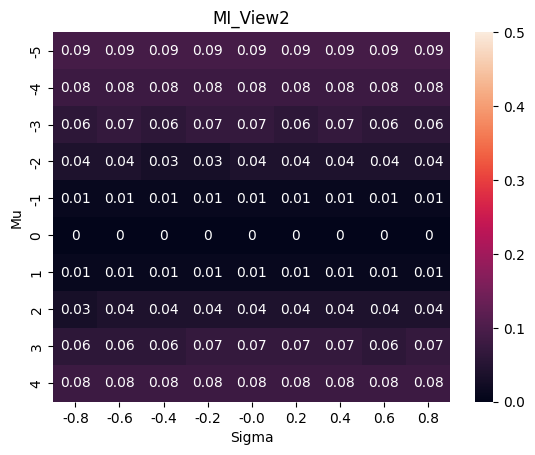

In [96]:
mi_view2_df = pd.DataFrame(np.round(mi_v2,2),index = np.arange(-5, 5) ,columns = np.round(np.arange(-0.8,1,0.2),2))
sns.heatmap(mi_view2_df,annot = True,vmin = 0,vmax = 0.5)
plt.xlabel('Sigma')
plt.ylabel('Mu')
plt.title("MI_View2")

Text(0.5, 1.0, 'MI_Diff')

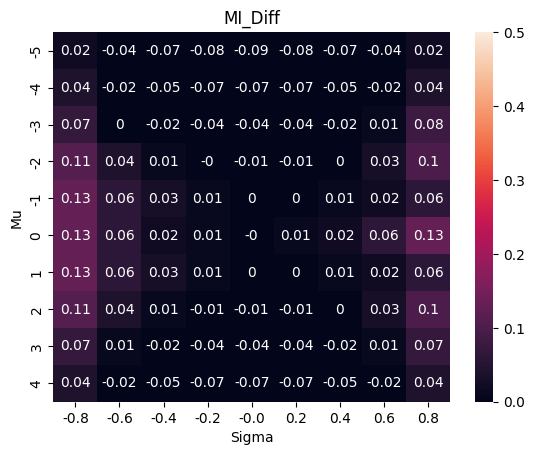

In [97]:
MI_diff = pd.DataFrame(np.round(MI,2),index = np.arange(-5, 5) ,columns = np.round(np.arange(-0.8,1,0.2),2))
sns.heatmap(MI_diff,annot = True,vmin = 0,vmax = 0.5)
plt.xlabel('Sigma')
plt.ylabel('Mu')
plt.title("MI_Diff")

Text(0.5, 1.0, 'S98_Diff')

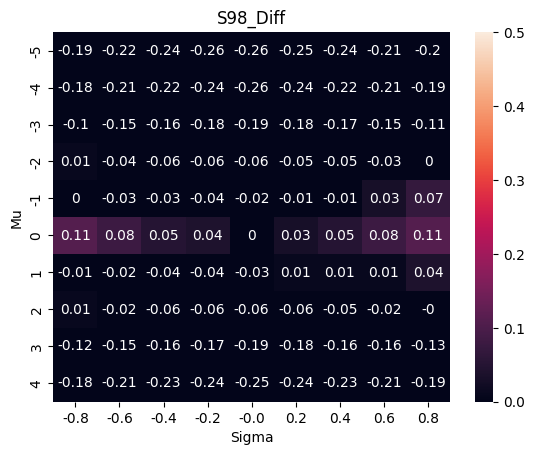

In [89]:
s98_diff = pd.DataFrame(np.round(s98,2),index = np.arange(-5, 5) ,columns = np.round(np.arange(-0.8,1,0.2),2))
sns.heatmap(s98_diff,annot = True,vmin = 0,vmax = 0.5)
plt.xlabel('Sigma')
plt.ylabel('Mu')
plt.title("S98_Diff")